In [1]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import scipy.ndimage
from scipy import fftpack

In [2]:
image_file = fits.open('file:///C:/cygwin64/home/rehg98/WLconv_z1100.00_0580r.fits')
image_file.info()
type(image_file)

Filename: C:\Users\rehg98\.astropy\cache\download\py3\1c6f961384c074b1b25de6c1f4fd2344
No.    Name         Type      Cards   Dimensions   Format
  0  PRIMARY     PrimaryHDU       7   (2048, 2048)   float32   


astropy.io.fits.hdu.hdulist.HDUList

In [3]:
image_data = image_file[0].data
image_data = image_data.astype(float)
print(image_data)

[[ 0.28772882  0.31463188  0.31120118 ..., -0.26744589 -0.26138833
  -0.19891326]
 [ 0.23843557  0.26356095  0.27608296 ..., -0.10312956 -0.11086034
  -0.06235358]
 [ 0.32085782  0.3036944   0.35584533 ..., -0.12078809 -0.05707451
  -0.07544205]
 ..., 
 [ 0.30768567  0.30357176  0.30380633 ..., -0.19853105 -0.15406299
  -0.17564408]
 [ 0.16823567  0.13827965  0.25008214 ..., -0.21506804 -0.12519895
  -0.26080811]
 [ 0.19998959  0.20467333  0.2182963  ..., -0.25283489 -0.12982941
  -0.30584782]]


In [4]:
F = fftpack.fftshift(fftpack.fft2(image_data))
psd2D = np.abs(F)**2

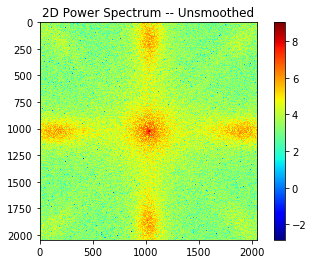

In [5]:
plt.imshow(np.log10(psd2D), cmap=plt.cm.jet)
plt.title("2D Power Spectrum -- Unsmoothed")
plt.colorbar()
plt.show()

In [6]:
smooth_data = scipy.ndimage.filters.gaussian_filter(image_data, 100)
F_smooth = fftpack.fftshift(fftpack.fft2(smooth_data))
psd2D_smooth = np.abs(F_smooth)**2

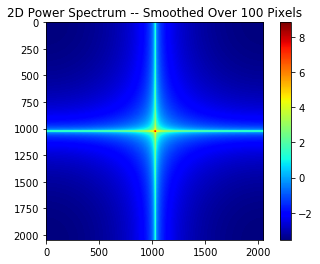

In [7]:
plt.imshow(np.log10(psd2D_smooth), cmap=plt.cm.jet)
plt.title("2D Power Spectrum -- Smoothed Over 100 Pixels")
plt.colorbar()
plt.show()

In [176]:
def power1D(image):
    #help from Jessica Lu's radialProfile module (http://www.astrobetter.com/wiki/tiki-index.php?page=python_radial_profiles)
    y, x = np.indices(image.shape)
    center = np.array([(x.max() - x.min()) / 2., (y.max() - y.min()) / 2.])
    
    radii = np.hypot(x - center[0], y - center[1])
    max_radius = x.max() - center[0]
    
    sorted_radii_indices = np.argsort(radii.flat)
    sorted_radii = radii.flat[sorted_radii_indices]
    max_radius_index = np.where(sorted_radii >= max_radius)[0][0]
    
    sorted_radii = sorted_radii[:max_radius_index]
    sorted_pixels = image.flat[sorted_radii_indices[:max_radius_index]]
    
    num_bins = 100
    bins = np.linspace(0, (image.shape[0] - 2) / 2., num_bins + 1)
    binplace = np.digitize(sorted_radii, bins)
    bin_content = [0] * (bins.size - 1)
    bin_sums = [0] * (bins.size - 1)
    
    for n in range(bins.size - 1):
        bin_elements = sorted_pixels[np.where(binplace == (n+1))]
        bin_content[n] = bin_elements.size
        bin_sums[n] = np.sum(bin_elements)
        
    bin_content = np.array(bin_content)
    bin_sums = np.array(bin_sums)
    
    bin_averages = bin_sums / bin_content
    return bin_averages

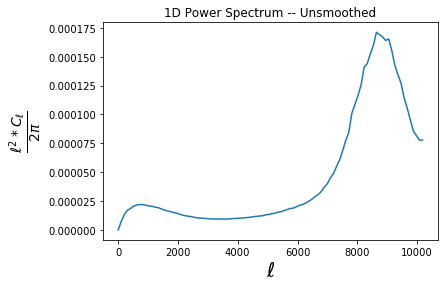

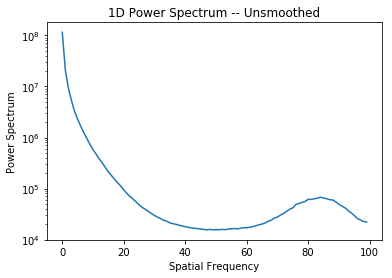

In [208]:
psd1D = power1D(psd2D)

side_map_deg = 3.5
side_map_pix = 2046
ell = np.arange(psd1D.size) * 360./side_map_deg
power = psd1D * ((2*np.pi*side_map_deg/360.0)**2)/(side_map_pix**2)**2


plt.plot(ell, ell**2 * power / (2*np.pi))  #new plot -- I used ell_pixel = x values from previous plot
                                           #and power_pixel = y values from previous plot. Is this incorrect?
plt.title('1D Power Spectrum -- Unsmoothed')
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$\frac{\ell^2 * C_\ell}{2\pi}$', fontsize = 20)
plt.show()

plt.semilogy(psd1D)   #previous plot -- array values from power1D() on y-axis, indices of array on x-axis
plt.title('1D Power Spectrum -- Unsmoothed')
plt.xlabel('Spatial Frequency')
plt.ylabel('Power Spectrum')
plt.show()

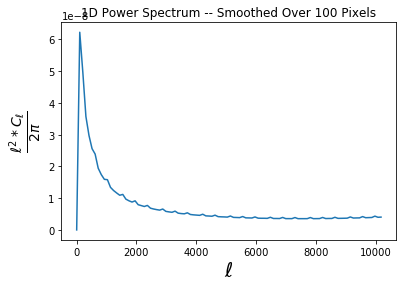

In [204]:
psd1D_smooth = power1D(psd2D_smooth)

ell_smooth = np.arange(psd1D_smooth.size) * 360./side_map_deg
power_smooth = psd1D_smooth * ((2*np.pi*side_map_deg/360.0)**2)/(side_map_pix**2)**2

plt.plot(ell_smooth, ell_smooth**2 * power_smooth / (2*np.pi))
plt.title('1D Power Spectrum -- Smoothed Over 100 Pixels')
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$\frac{\ell^2 * C_\ell}{2\pi}$', fontsize = 20)
plt.show()